# Servicios Interconnect

Durante el proceso de todo este documento realizaremos el análisis de los datos proporcionados por la empresa, seguiremos el plan de trabajo, y desarrollaremos una solución útil, que cumpla con las expectativas requeridas para la predicción de baja de clientes.

## Descripción del problema

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

### Perspectiva del problema

Interconnect proporciona principalmente dos tipos de servicios:

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

### Descripción de los datos

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.

## Importe de librerías y Carga de datos

In [3]:
# Pandas para el manejo de datos
import pandas as pd
# Sklearn para prácticas y modelado de aprendizaje automático
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as skmet
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler
# Plotly y Seaborn para mostrar los datos en gráficos dinámicos
import seaborn as sns
import matplotlib.pyplot as plt
# Numpy para operaciones específicas de matricez y números
import numpy as np
# Impotamos el modelo de LightGBM para probar diferente efectividad
import lightgbm as lgb

In [4]:
# Haremos referencia a nuestros archivos csv para cargar los datos a dataframes
# Contract
df_contract = pd.read_csv('../datasets/contract.csv')
# Personal
df_personal = pd.read_csv('../datasets/personal.csv')
# Internet
df_internet = pd.read_csv('../datasets/internet.csv')
# Phone
df_phone = pd.read_csv('../datasets/phone.csv')

## Combinación de dataframes

Revisando todos los dataframes, podemos observar que todos se manejan por id de cliente como la manera de identificarse, esto nos puede ayudar a crear un dataframe completo con todas las características de cada cliente.

In [5]:
# Revisemos las dimensiones de los dataframes
print(f"Contract:  {df_contract.shape}")
print(f"Personal:  {df_personal.shape}")
print(f"Internet:  {df_internet.shape}")
print(f"Phone:     {df_phone.shape}")

Contract:  (7043, 8)
Personal:  (7043, 5)
Internet:  (5517, 8)
Phone:     (6361, 2)


Podemos observar que no todos los dataframes cuentan con todos los clientes registrados, ya que 7043 debería de ser nuestro número total de clientes. 

Optaremos por tomar todos los ids que aparezcan en los 4 dataframes juntos para saber de cuantos clientes se tiene toda la información.

In [6]:
# Toma los ids de cada dataframe y solo deja los que no se repiten
common_ids = set(df_contract['customerID']) & set(df_personal['customerID']) & set(df_internet['customerID']) & set(df_phone['customerID'])
print(f"Encontramos que {len(common_ids)} clientes aparecen en las 4 tablas, por lo que tenemos toda su información respectiva de cada tabla")

Encontramos que 4835 clientes aparecen en las 4 tablas, por lo que tenemos toda su información respectiva de cada tabla


Ahora debemos mezclar todas las características de los dataframes a uno solo para poder trabajar con todos los campo correspondientes

In [7]:
# Primer transformaremos nuestra lista set a un arreglo
customerID_list = np.array(list(common_ids))
# Crea un dataframe con todos los ids comunes en los 4 dataframes
common_df = pd.DataFrame({'customerID':customerID_list})

In [8]:
# Después usamos el dataframe de ids comunes para combinar con cada uno de los dataframes
# y quedarnos solo con las columnas que nos interesan
df = df_contract.merge(df_personal, on='customerID', how='inner') \
               .merge(df_internet, on='customerID', how='inner') \
               .merge(df_phone, on='customerID', how='inner')

In [9]:
df.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
1,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
2,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
3,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
4,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes


Para el futuro de todo el análisis, solamente usaremos los 4835 clientes encontrados.

## Procesamiento de datos

Para el procesamiento de datos, es necesario deshacerse de los datos atípicos, nulos, duplicados y formatear los datos a tipos de datos útiles o correspondientes a cada columna. Estos datos serán la base de nuestro trabajo, por lo que es necesario que estén limpios y sean de alta calidad para poder trabajar con ellos.

Obtenemos una muestra de los datos y la información general nu

### Panorama del dataset

In [10]:
# Representamos los valores de los primeros 5 clientes
df.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
1,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
2,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
3,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
4,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes


In [11]:
# Información general de el dataset contract.csv
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        4835 non-null   object 
 1   BeginDate         4835 non-null   object 
 2   EndDate           4835 non-null   object 
 3   Type              4835 non-null   object 
 4   PaperlessBilling  4835 non-null   object 
 5   PaymentMethod     4835 non-null   object 
 6   MonthlyCharges    4835 non-null   float64
 7   TotalCharges      4835 non-null   object 
 8   gender            4835 non-null   object 
 9   SeniorCitizen     4835 non-null   int64  
 10  Partner           4835 non-null   object 
 11  Dependents        4835 non-null   object 
 12  InternetService   4835 non-null   object 
 13  OnlineSecurity    4835 non-null   object 
 14  OnlineBackup      4835 non-null   object 
 15  DeviceProtection  4835 non-null   object 
 16  TechSupport       4835 non-null   object 


Gracias a la vista general que proporciona el método info(), podemos apreciar que no se encuentra ningún valor nulo dentro de el dataframe

### Formatéo y Procesamiento de Columnas

Podemos observar que necesitamos formatear algunos tipos de datos.

* La columna `BeginDate` se transformará a tipo **datetime** para manipular más fácilmente los datos de tipo fecha y posteriormente se desglozarán en año mes y día. Mientras que la columna `EndDate` se transformará en tipo binaría para saber que clientes pertenecen al servicio y cuales ya se han dado de baja.
* Las columnas `Type`, `PaymentMethod`, `InternetService` se puede transformar usando One Hote Encoding, volviendo los datos de tipo **object** a tipo **numérico**.
* La columna `TotalCharges` también debería de poder ser tipo **float** ya que expresa el costo total de el servicio.
* La columnas `PaperlessBilling`, `Partner`, `Dependents`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `MultipleLines` se pueden convertir a typo binario ya que solo maneja valores "Yes" o "No".
* La columna `gender` se puede transformar a una columna binaria también, manejando Hombres 1 y mujeres 0

#### BeginDate y EndDate

In [12]:
# Verificamos los datos que contiene la columna
df['EndDate'].value_counts()

EndDate
No                     3249
2019-11-01 00:00:00     414
2019-10-01 00:00:00     401
2019-12-01 00:00:00     392
2020-01-01 00:00:00     379
Name: count, dtype: int64

In [13]:
# Transformaremos la columna BeginDate a datetime
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')
# Separamos la columna BeginDate a año més y día
df['BeginYear'] = df['BeginDate'].dt.year
df['BeginMonth'] = df['BeginDate'].dt.month
df['BeginDay'] = df['BeginDate'].dt.day
# Nos des hacemos de la columna BeginDate
df = df.drop(['BeginDate'],axis=1)
# y transformaremos la columna EndDate a binaria
df['EndDate'] = df.apply(lambda row: 0 if row['EndDate'] in 'No' else 1, axis=1)
df['EndDate'] = df['EndDate'].astype('int64')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        4835 non-null   object 
 1   EndDate           4835 non-null   int64  
 2   Type              4835 non-null   object 
 3   PaperlessBilling  4835 non-null   object 
 4   PaymentMethod     4835 non-null   object 
 5   MonthlyCharges    4835 non-null   float64
 6   TotalCharges      4835 non-null   object 
 7   gender            4835 non-null   object 
 8   SeniorCitizen     4835 non-null   int64  
 9   Partner           4835 non-null   object 
 10  Dependents        4835 non-null   object 
 11  InternetService   4835 non-null   object 
 12  OnlineSecurity    4835 non-null   object 
 13  OnlineBackup      4835 non-null   object 
 14  DeviceProtection  4835 non-null   object 
 15  TechSupport       4835 non-null   object 
 16  StreamingTV       4835 non-null   object 


Logramos obtener las fechas de Fin igualadas a la fecha de inicio cuando el valor es "No"

#### Type, PaymentMethod, InternetService

In [15]:
# Creamos las columnas OneHotEncoding, donde si tiene el mismo nombre de la columna, el valor se representará en
# 1, mientras que el contrario se representará en 0
one_hot_type = pd.get_dummies(df["Type"], prefix = 'Type')
one_hot_paymentMethod = pd.get_dummies(df["PaymentMethod"], prefix = 'PaymentMethod')
one_hot_internetService = pd.get_dummies(df["InternetService"], prefix = 'InternetService')

In [16]:
# Unimos el OHE a nuestro dataframe
df = pd.concat([df, one_hot_type, one_hot_paymentMethod, one_hot_internetService], axis=1)
df = df.drop('Type', axis=1)
df = df.drop('PaymentMethod', axis=1)
df = df.drop('InternetService', axis=1)
df.columns

Index(['customerID', 'EndDate', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'BeginYear',
       'BeginMonth', 'BeginDay', 'Type_Month-to-month', 'Type_One year',
       'Type_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_DSL', 'InternetService_Fiber optic'],
      dtype='object')

#### TotalCharges

In [17]:
print(f"Número de clientes con valor vacío de cargos totales: {len(df[df['TotalCharges'] == ' '])}")

Número de clientes con valor vacío de cargos totales: 3


Encontramos cargos totales vacíos. Ya que el número de clientes que lo tienen son solamente 3 entre nuestros más de 4385 clientes registrados, optaremos por borrar estos ejemplares para que no interfieran con los resultados ni filtrado de datos.

In [18]:
# Eliminamos las filas que contengan un valor vacío en la columna TotalCharges
df = df[df['TotalCharges'] != ' ']
len(df)

4832

Ahora solo poseemos de 4832 clientes en nuestro dataset

In [19]:
# Comprobamos si es posible cambiar el tipo de valor de "object" a "float"
np.array_equal(pd.to_numeric(df['TotalCharges'], errors='coerce'), df['TotalCharges'].astype('float')) # False

True

In [20]:
# Convertimos los valores a flotantes y asignamos el tipo float para la columna
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').astype('float')

#### Columnas Binarias "Yes" y "No"

In [21]:
# Revisamos los valores existentes en la columna
columnsBinary = ["PaperlessBilling",
                 "Partner",
                 "Dependents",
                 "OnlineSecurity",
                 "OnlineBackup",
                 "DeviceProtection",
                 "TechSupport",
                 "StreamingTV",
                 "StreamingMovies",
                 "MultipleLines"]

In [22]:
# Recorremos todas las columnas que tienen como valores "Yes" y "No"
for col in columnsBinary:
    print(f"{col}:")
    #Antes del cambio
    print(f"{df[col].value_counts().index.values} {df[col].dtype}")
    # Reemplaza valor True cuando encuentre la palabra "Yes" y False al encontras la palabra "No"
    df[col] = df[col].apply(lambda x: 1 if "Yes" in x else 0)
    # Después del cambio
    print(f"{df[col].value_counts().index.values} {df[col].dtype}")
    print()


PaperlessBilling:
['Yes' 'No'] object
[1 0] int64

Partner:
['No' 'Yes'] object
[0 1] int64

Dependents:
['No' 'Yes'] object
[0 1] int64

OnlineSecurity:
['No' 'Yes'] object
[0 1] int64

OnlineBackup:
['No' 'Yes'] object
[0 1] int64

DeviceProtection:
['No' 'Yes'] object
[0 1] int64

TechSupport:
['No' 'Yes'] object
[0 1] int64

StreamingTV:
['Yes' 'No'] object
[1 0] int64

StreamingMovies:
['Yes' 'No'] object
[1 0] int64

MultipleLines:
['Yes' 'No'] object
[1 0] int64



In [23]:
# Revisamos el tipo de dato de la columna
df['PaperlessBilling'].dtype

dtype('int64')

#### Gender

In [24]:
# Finalmente volvemos la columna genre a binaria para representar hombres como 1 y mujeres como 0
# Esto ayudará mejor en el procesamiento a la hora de entrenar al modelo
df['gender'] = df['gender'].apply(lambda g: 0 if 'Female' in g else 1)
# Representamos la cantidad de valores en la columna
df['gender'].value_counts()

gender
1    2424
0    2408
Name: count, dtype: int64

In [25]:
# Confirmamos el tipo
df['gender'].dtype

dtype('int64')

#### Fin de el Procesamiento de datos

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4832 entries, 0 to 4834
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customerID                               4832 non-null   object 
 1   EndDate                                  4832 non-null   int64  
 2   PaperlessBilling                         4832 non-null   int64  
 3   MonthlyCharges                           4832 non-null   float64
 4   TotalCharges                             4832 non-null   float64
 5   gender                                   4832 non-null   int64  
 6   SeniorCitizen                            4832 non-null   int64  
 7   Partner                                  4832 non-null   int64  
 8   Dependents                               4832 non-null   int64  
 9   OnlineSecurity                           4832 non-null   int64  
 10  OnlineBackup                             4832 non-nul

Podemos observar que ahora hemos convertido a todas nuestras columnas en variabler numéricas, lo que nos ayudará a usarlas en el modelo de machine learning como características predictivas.

In [27]:
# Finalmente representamos los nuevos datos
df.head(5)

,customerID,EndDate,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,...,BeginDay,Type_Month-to-month,Type_One year,Type_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic
0,5575-GNVDE,0,0,56.95,1889.50,1,0,0,0,1,...,1,False,True,False,False,False,False,True,True,False
1,3668-QPYBK,1,1,53.85,108.15,1,0,0,0,1,...,1,True,False,False,False,False,False,True,True,False
2,9237-HQITU,1,1,70.70,151.65,0,0,0,0,0,...,1,True,False,False,False,False,True,False,False,True
3,9305-CDSKC,1,1,99.65,820.50,0,0,0,0,0,...,1,True,False,False,False,False,True,False,False,True
4,1452-KIOVK,0,1,89.10,1949.40,1,0,0,1,0,...,1,True,False,False,False,True,False,False,False,True


Finalizando podemos ver que todas nuestras columnas ahora tienen un valor y tipo adecuado para que el análisis y el entrenamiento del modelo seán más sencillos

## Análisis Exploratorio de Datos (EDA)

Después de haber limpiado y transformado nuestros datos en valores útiles para nuestra investigación y análisis. Realizaremos un análisis de datos estadísticos, en donde analizaremos las relaciones que tienen las variables de nuestro dataset, además de crear gráficos que nos ayuden a entender las cifras con las que tratamos en cada característica que tenemos.

### Matríz de Correlación

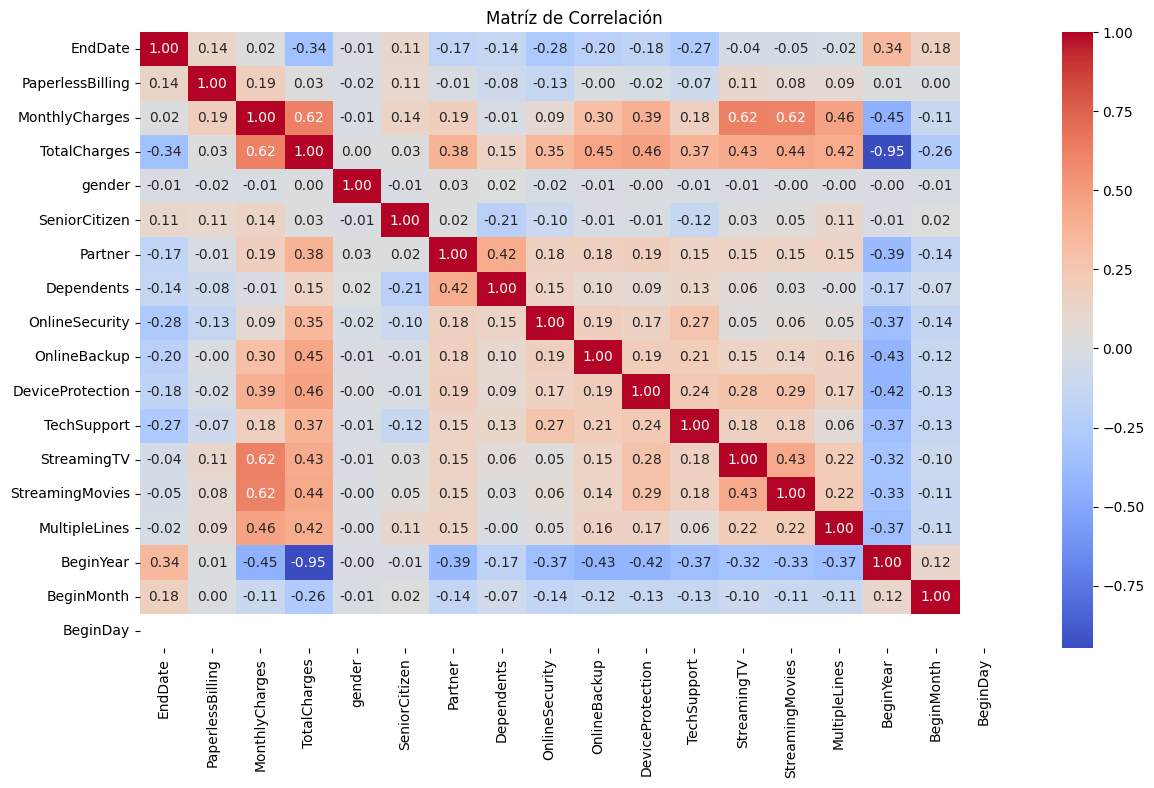

In [28]:
# Obtenemos solo las columnas numéricas
df_numeric = df.select_dtypes(include='number')
# Revisaremos la correlación de cada columna entre sí para tener un buen panorama sobre el comportamiento del cliente
plt.figure(figsize=(14, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matríz de Correlación")
plt.show()

En este gráfico extenso, podemos notar algunos patrones en los datos.
* Primeramente podemos notar los valores que se acercan más a los tonos rojos, que significan alta correlación. Como lo son la relación de:
  * `StreamingTV`, `StreamingMovies`, `Multiple Lines` y `Total Charges`, a la variable `Monthly Charges`
  * Y la relación de `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `Streaming Movies`, `MultipleLines` y `Type_Two_Year` a la columna `Total Charges`, Lo que nos quiere decir que todas estas afectan a el precio total de ventas
* Otro patrón que podemos notar es que la variable `Type_Month_to_Month`, no parece tener muy poca relación con la mayoría de nuestras variables en nuestro dataset, esto podría indicar que no es un claro indicador de como se comporta el cliente

### Columnas Binarias

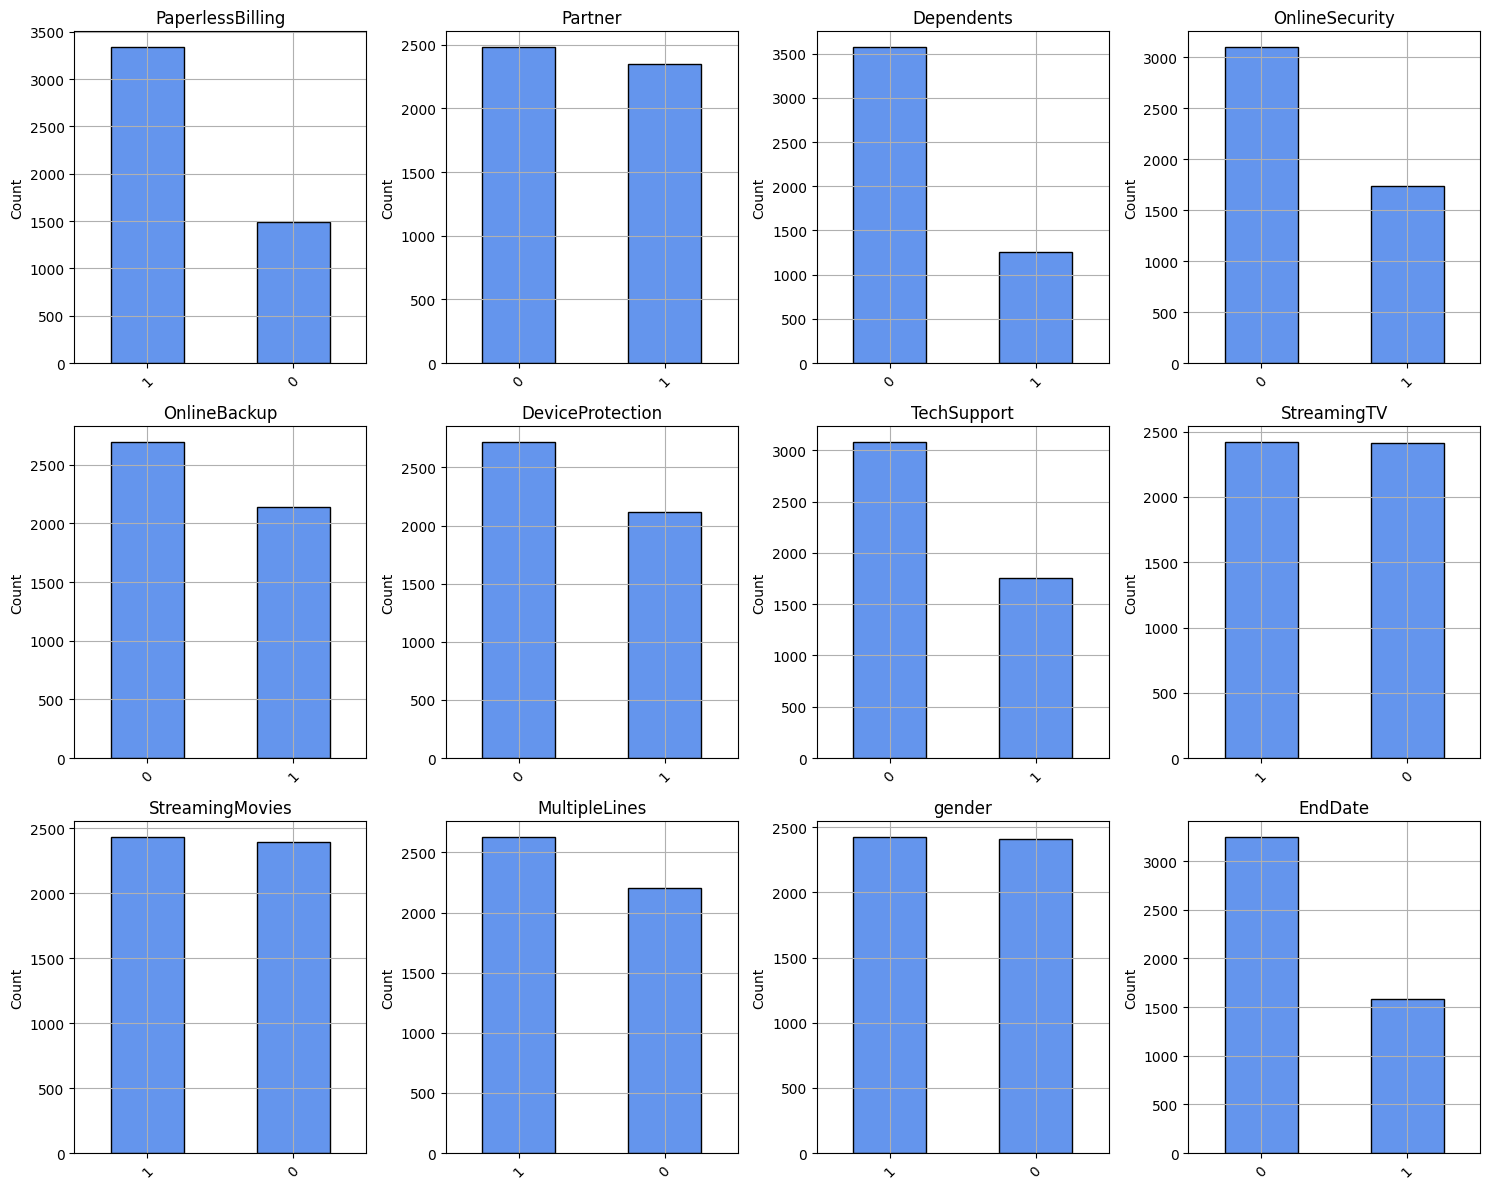

In [29]:
# Usamos la variable donde guardamos todos los nombres de las columnas binarias
# Y le agregamos la columna gender y EndDate
columnsBinary.extend(['gender','EndDate'])
# Especificamos un gri de 3x4
n_rows, n_cols = 3, 4
# Creamos las dimensiones del gráfico
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
axes = axes.flatten()  # to index like a list

# Iteramos por cada columna binaria
for i, col in enumerate(columnsBinary):
    df[col].value_counts().plot(kind='bar', ax=axes[i], color='cornflowerblue', edgecolor='black')
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True)

# Esconde las gráficas que no se usen (si columnsBinary < 12)
for j in range(len(columnsBinary), n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Después de ver los siguientes gráficos, podemos identificar lo siguiente:
* Algunas columnas tienen la misma o un gran parecido de resultados como: `Partner`, `StreamingTV`, `StreamingMovies`, `gender`
  * Para las columnas Partner, y Gender, es muy bueno tener estos resultados, ya que nos habla de que los datos están bien distribuídos entre diferentes tipos de clientes
* Otras columnas varían un poco como `OnlineSecurity`, `OnlineBackup`, `DeviceProtection` y `MultipleLines`
* Y finalmente tenemos públicos más grandes que otros al observar las colmnas `PaperlessBilling`, `Dependants`, `TechSupport`y `EndDate`
  * De estos gráficos podemos identificar que los clientes prefieren facturación en línea
  * Hay más personas tienen soporte técnico
  * Un poco menos de la mitad de las personas registradas se han dado de baja del servicio

### Inscripciones por Mes

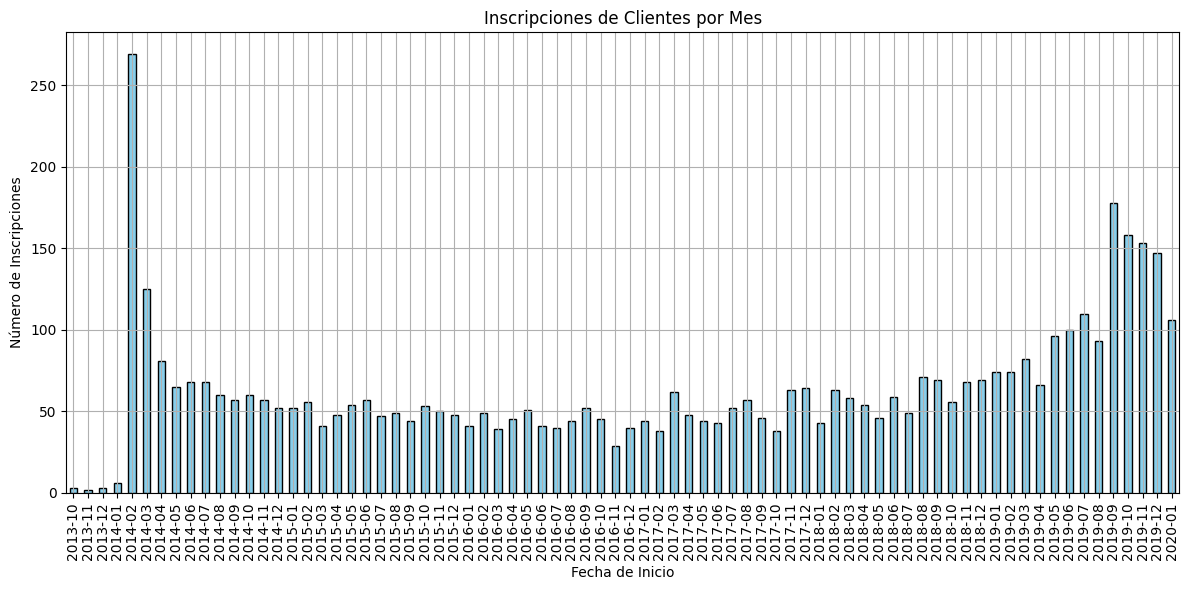

In [30]:
yearMonthInscriptions = pd.to_datetime(df['BeginYear'].astype(str) + '-' + df['BeginMonth'].astype(str))
# Contamos a todos los clientes que se hallan inscrito en cada mes
signups_per_month = df.groupby(yearMonthInscriptions.dt.to_period('M')).size()
# Creamos una gráfica donde mostremos el total de clientes suscritos cada mes
plt.figure(figsize=(12, 6))
# Creamos la gráfica a partir de el dataframe
signups_per_month.plot(kind='bar', color='skyblue', edgecolor='black')
# Asignamos los títulos y etiquetas
plt.title('Inscripciones de Clientes por Mes')
plt.xlabel('Fecha de Inicio')
plt.ylabel('Número de Inscripciones')
# Rotamos los títulos para que aparezcan verticales
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(True)
# Mostramos el gráfico
plt.show()

Gracias a este gráfico, podemos apreciar que hubo un gran aumento de clientes registrados el més de Febrero del año 2014. A su vez podemos ver que posteriormente hasta Abril del 2019, las inscripciones se habían mantenido el promedio, entre las 50 y 60 personas. Por último, podemos apreciar que después de todos esos meses hay un aumento de inscripciones que desde el més de Septiembre del año 2019.

## Desarrollo de Modelos de Machine Learning

Procederemos a entrenar a nuestros modelos mediante los datos que hemos conseguido en este análisis, para poder conseguir predicciones acerca de las bajas de los clientes a los servicios de la empresa.

### Creación de características de entrenamiento y de prueba

In [31]:
# Optaremos primero por definir cuales serán nuestras variables que nos darán la pista para definir si un cliente se dará de baja
features = df.drop(['EndDate','customerID'], axis = 1)
# Y obtendremos la columna con nuestro objetivo, el cuál es la variable que queremos predecir
target = df['EndDate']

# Separaremos nuestros datos en datas de entrenamiento y datos de prueba, siendo los datos de prueba un 25% de los datos que se tienen
features_train, features_valid, target_train, target_valid = train_test_split(
    features,target,test_size=0.25,random_state=12345)

# Escalar los datos de precios
scaler = StandardScaler()
features[['MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(features[['MonthlyCharges', 'TotalCharges']])

In [32]:
# Función para crear curva AUC-ROC con score
def AucRocGraphScore(target_valid, target_proba):
    roc_auc = roc_auc_score(target_valid, target_proba)
    fpr, tpr, _ = roc_curve(target_valid, target_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC-AUC Score = {roc_auc:.4f}", color='darkorange')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Logistic Regression")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

### Entrenamiento del Modelo Logistic Regression y curva AUC ROC

In [33]:
# Utilizaremos el modelo Linear Regression para predecir si se tiene aviso de que un cliente se dará de baja
model = LogisticRegression(max_iter=1000)
# Entrenamiento de modelo
model.fit(features_train,target_train)
# Obtiene las probabilidades de las predicciones del modelo en el conjunto de validación
target_proba = model.predict_proba(features_valid)[:, 1]

c:\Users\ISALAS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


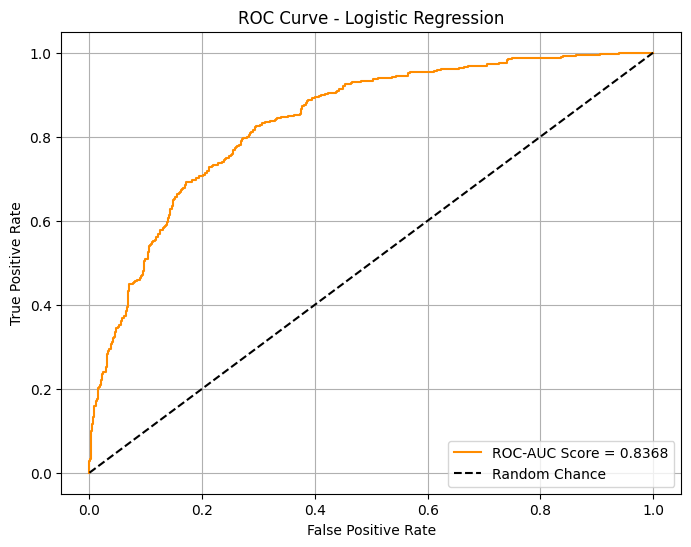

In [34]:
AucRocGraphScore(target_valid, target_proba)

### Entrenamiento del Modelo LightGBM y curva AUC ROC

In [35]:
# Prepararemos los datasets para nuestro modelo LigthGBM
train_data = lgb.Dataset(features_train, label=target_train)
test_data = lgb.Dataset(features_valid, label=target_valid, reference=train_data)

In [36]:
# Usaremos los siguientes parámetros para nuestro modelo
params = {
    # Nuestro objetivo hace referencia a nuestra variable target que es binaria
    'objective': 'binary',
    # Utilizaremos la métrica auc-roc
    'metric': 'auc',
    # Para el tipo de boosting, usaremos gradient boosting descent gbdt
    'boosting_type': 'gbdt',
    # Con un aprendizaje del 0.05
    'learning_rate': 0.05,
    # Número de hojas en el modelo a entrenar
    'num_leaves': 31,
    'verbose': -1,
    # Majenamos el desbalance de clase dándole importancia a la clase minoritatia
    'scale_pos_weight': (target == 0).sum() / (target == 1).sum()  # handle imbalance
}

Podemos observar que la curva formada tiene una buena dirección hacia las predicciones, Lo que demuestra que el modelo va por buena dirección.

In [42]:
model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.907516
[200]	valid_0's auc: 0.91878
[300]	valid_0's auc: 0.921977
[400]	valid_0's auc: 0.923682
Early stopping, best iteration is:
[389]	valid_0's auc: 0.923956


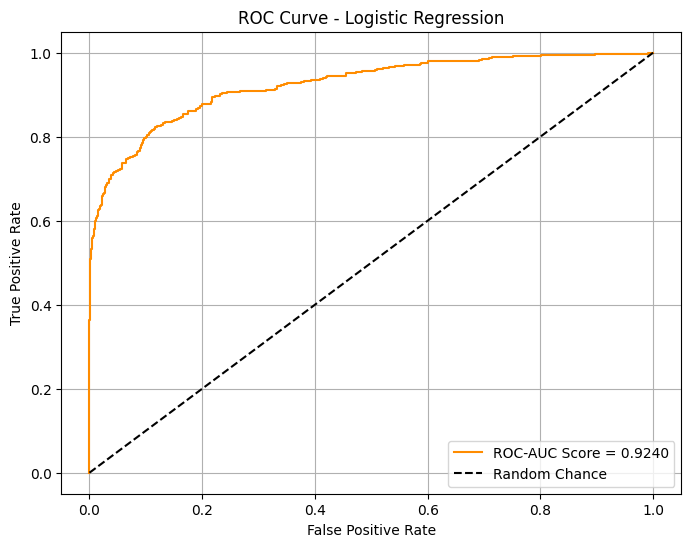

In [43]:
target_proba = model.predict(features_valid, num_iteration=model.best_iteration)
AucRocGraphScore(target_valid, target_proba)

### Resultados

In [44]:
target_pred = (target_proba >= 0.5).astype(int)
print(classification_report(target_valid, target_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       822
           1       0.78      0.80      0.79       386

    accuracy                           0.87      1208
   macro avg       0.84      0.85      0.85      1208
weighted avg       0.87      0.87      0.87      1208



El reporte de clasificación muestra el desempeño del modelo LightGBM en la predicción de bajas de clientes. Los principales indicadores son:

- **Precisión (precision):** Indica la proporción de verdaderos positivos entre todas las predicciones positivas. Un valor alto significa que el modelo comete pocos falsos positivos.
- **Exhaustividad (recall):** Mide la proporción de verdaderos positivos identificados correctamente entre todos los casos reales positivos. Un valor alto indica que el modelo detecta la mayoría de las bajas reales.
- **F1-score:** Es la media armónica entre precisión y exhaustividad, proporcionando una visión equilibrada del desempeño del modelo.
- **Soporte (support):** Es la cantidad de muestras reales de cada clase en el conjunto de validación.

En general, valores altos en precisión, recall y F1-score para ambas clases indican que el modelo es efectivo tanto para identificar clientes que se darán de baja como para aquellos que permanecerán. Esto respalda la utilidad del modelo para apoyar decisiones de negocio orientadas a la retención de clientes.

## Conclusión

Gracias a nuestro análisis ahora tenemos un panorama mucho más amplio de el comportamiento de los usuarios como:
* Que fechas fueron las que más se inscribieron usuarios
* Cuando las ventas se estabilizaron
* Y la situación actual de la empresa, la cual se encuentra aumentando ventas desde los últimos 8 meses

Gracias al análisis también pudimos observar cuáles son las preferencias de la mayoría de los clientes a la hora de usar el servicio como:
* Que la mayoría prefieren facturar en línea
* Que una porción grande de clientes prefiere tener soporte técnico, Seguridad
* A su vez pudimos observar que la mitad de los que se unieron al servicio lo terminaron abandonando, lo que da a entender la preopcupación e importancia de este análisis para la empresa

Por último, pudimos lograr crear 2 tipos de modelos los cuales dieron los siguientes resultados:
* **Modelo de Regresión Logística**
    * Nuestro modelo de regresión logística, logró obtener un porcentaje en nuestra métrica AUC-ROC de **83.44%**, lo que signifífca que nuestro modelo pareció ser bastante bueno con las predicciones al poder acertar un 83 porciento de las veces con las bajas del cliente.
* **Modelo LightGBM**
    * Por otro pudimos observar un mejor modelo de Gradient Boosting, en donde, entrenado con los mismo datos, pudimos notar que el desempeño escaló muy por delante de nuestro primer modelo, consiguiendo así un **92.40%** de porcentaje en la esacala AUC-ROC. Lo cuál indica que es un modelo áltamente capaz de hacer buenas predicciones.

Después de haber visto los siguientes resultados, podemos dar por conlucída la meta estimada sobre el análisis y la predicción de bajas de clientes en la empresa, para así poder tomar decisiones en base a los resultados obtenidos.

En resumen, este análisis nos ha permitido comprender en profundidad el comportamiento y las tendencias de los clientes de Interconnect. Identificamos los periodos clave de inscripción, los factores que influyen en la permanencia o baja de los usuarios, y las preferencias predominantes en cuanto a servicios y métodos de facturación. Además, la aplicación de modelos de machine learning robustos ha demostrado ser una herramienta valiosa para anticipar la cancelación de clientes, permitiendo a la empresa diseñar estrategias proactivas de retención. Estos hallazgos no solo fortalecen la toma de decisiones basada en datos, sino que también abren la puerta a futuras optimizaciones en la gestión y personalización de servicios, consolidando la competitividad de la empresa en el mercado.